## Tuto fonction fastmri

## Import

In [1]:
import sys
sys.path.append('/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon')

In [2]:
from fastmri.data import transforms as T
import h5py
import torch
import numpy as np
from matplotlib import pyplot as plt

from utils_torch import virtual_coil_reconstruction, show_coils


## Download data 

In [3]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"
hf = h5py.File(file_path)

## Manipulate data to understand and have the right format

Les données sont complex.  
Shape = [Batch , coils , H, W]

In [4]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)
# print(volume_kspace)

complex64
(16, 16, 640, 320)


Visualisation des données : kspace

In [5]:
slice_kspace = volume_kspace[volume_kspace.shape[1]-1] 

# for coil_index in range(slice_kspace.shape[0]):
#     show_coils(np.log(np.abs(slice_kspace) + 1e-9), [coil_index])

volume_kspace= torch.tensor(volume_kspace, dtype=torch.complex64)

Visualisation des données : images (NE SERT A RIEN)

In [6]:
dimension = len(volume_kspace.shape) -2
if dimension == 2 :
    slice_image = torch.fft.ifft2(volume_kspace)
else: 
    slice_image = torch.fft.ifftn(volume_kspace)
slice_image = torch.fft.fftshift(slice_image)

slices_images = slice_image[slice_image.shape[1]-1]
# for coil_index in range(slices_images.shape[0]):
#     show_coils(np.log(np.abs(slices_images) + 1e-9), [coil_index])

## Multicoil to Singlecoil

torch.Size([16, 640, 320])


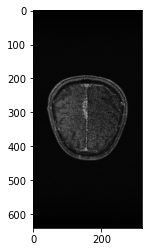

In [7]:
new_image_singlecoil = virtual_coil_reconstruction(slice_image)
print(new_image_singlecoil.shape)

image_goodShape = new_image_singlecoil[0]
plt.imshow(np.abs(image_goodShape.numpy()), cmap='gray')

In [8]:
# new_image_singlecoil = virtual_coil_reconstruction(volume_kspace)
# print(new_image_singlecoil.shape)

# new_image_singlecoil = torch.fft.ifft2(new_image_singlecoil)
# image_goodShape = new_image_singlecoil[0]
# image_goodShape = torch.fft.fftshift(image_goodShape)

# plt.imshow(np.abs(image_goodShape.numpy()), cmap='gray')

## Test for undersampling Mask 

### Re Manipulate the data to have the kspace 

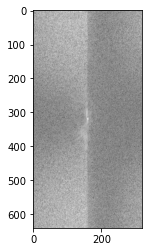

In [9]:
dimension = len(new_image_singlecoil.shape) - 1

if dimension == 2 :
    kspace_singlecoil = torch.fft.fft2(new_image_singlecoil)
else : 
    kspace_singlecoil = torch.fft.fftn(new_image_singlecoil)


kspace_goodShape = kspace_singlecoil[0]
plt.imshow(np.log(np.abs(kspace_goodShape.numpy())), cmap='gray')

### Fastmri

Choose the sampling mask you want between the following.

random : genere a sampling mask randomly  
equispaced : genere a sampling mask with qually-spaced k-space lines  
equispaced_fraction : similar to equispaced with more precision about acceleration rate  
magic : genere a sampling mask who exploit conjugate symmetry  
magic_fraction : similar to magic with more precision about acceleration rate  

In [10]:
from fastmri.data.subsample import create_mask_for_mask_type

mask_type_str = "equispaced_fraction"
center_fractions = [0.08, 0.04]
accelerations = [4, 8]

mask_func = create_mask_for_mask_type(mask_type_str, center_fractions, accelerations)

masked_func represent here the binary data of the mask.   
0 mean informatiosn in the data are note conserve.   
1 mean you take the information.   
    
accelerated_data is the fusion between the original data and sampling data.   
This is the data we gonna use.

In [11]:
masked_data , _ = mask_func(kspace_singlecoil.shape) 
accelerated_data_Kspace = kspace_singlecoil * masked_data
# print(accelerated_data_Kspace)
print(accelerated_data_Kspace.shape)

torch.Size([16, 640, 320])


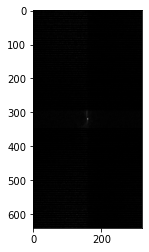

In [12]:
image_goodShape0 = accelerated_data_Kspace[0]
plt.imshow(np.abs(image_goodShape0.numpy()), cmap='gray')

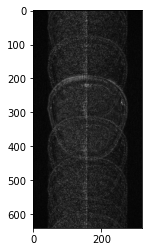

In [13]:
accelerated_data_image = torch.fft.ifft2(accelerated_data_Kspace)
image_goodShape0 = accelerated_data_image[0]
plt.imshow(np.abs(image_goodShape0.numpy()), cmap='gray')

### Fasmri Reproductible Benchmark

In [14]:
from data.gen_mask_torch import gen_mask_torch

In [15]:
#  Representation binaire qui indique quel point sera conservé. 

masked_data1 = gen_mask_torch(kspace_singlecoil, accel_factor= 4 , multicoil= False , fixed_masks=False)
accelerated_data1 = kspace_singlecoil * masked_data1
# print(accelerated_data)
print(accelerated_data1.shape)

torch.Size([16, 640, 320])


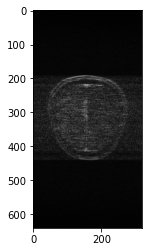

In [16]:
# image_goodShape1 = accelerated_data1[0]
# plt.imshow(np.abs(image_goodShape1.numpy()), cmap='gray')

accelerated_data_image1 = torch.fft.ifft2(accelerated_data1)
image_goodShape1 = accelerated_data_image1[0]
plt.imshow(np.abs(image_goodShape1.numpy()), cmap='gray')

## Result Sampling

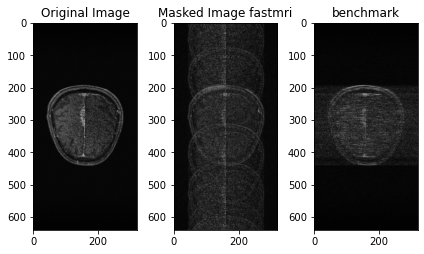

In [17]:

plt.subplot(1, 3, 1)
plt.imshow(np.abs(image_goodShape.numpy()), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(np.abs(image_goodShape0.numpy()), cmap='gray')
plt.title('Masked Image fastmri')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(image_goodShape1.numpy()), cmap='gray')
plt.title('benchmark')

plt.tight_layout()
plt.show()


## Modele Reseaux Neurones

In [18]:
from fastmri.models.unet import Unet

In [19]:
accelerated_data_unet = accelerated_data_image.unsqueeze(1)
print(accelerated_data_unet.shape)

torch.Size([16, 1, 640, 320])


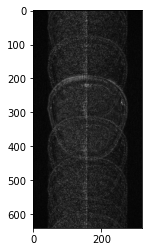

In [20]:
plt.imshow(np.abs(accelerated_data_unet[0, 0, :, :].numpy()), cmap='gray')

In [37]:
accelerated_data_unet_R = accelerated_data_unet.abs()
model = Unet(in_chans=accelerated_data_unet_R.shape[1], out_chans=1, chans=3 , num_pool_layers=2)
output_tensor = model(accelerated_data_unet_R)

In [38]:
print(output_tensor.shape)
# print(output_tensor)

torch.Size([16, 1, 640, 320])


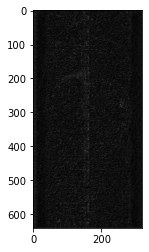

In [39]:
plt.imshow(np.abs(output_tensor[0, 0, :, :].detach().numpy()), cmap='gray')